In [1]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random.seed(6)
np.random.seed(6)


# Experiment 3

**Parameters:**
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)
- **This time the instruction are given as system prompt (i.e. the instruction are inserted between the system propmt tokens - <|system|>)**

Let's load the ground truth from the `STAR_question_and_stsg.json` file where we extracted QA and spatio-temporal scene graphs

In [2]:
ground_truth = []

with open('../data/datasets/STAR_question_and_stsg.json') as f:
    data = json.load(f)
    ground_truth = [{'id': sample['question_id'], 'answer': sample['answer']} for sample in data]


ground_truth_df = pd.DataFrame(ground_truth, dtype='string')
ground_truth_df.set_index('id', inplace=True)
gt_series = ground_truth_df['answer']

del ground_truth_df
gt_series


id
Interaction_T1_13             The clothes.
Interaction_T1_14             The clothes.
Interaction_T1_31             The clothes.
Interaction_T1_32                The shoe.
Interaction_T1_40      The closet/cabinet.
                              ...         
Feasibility_T6_1453        Wash the table.
Feasibility_T6_1454        Take the towel.
Feasibility_T6_1455        Wash the table.
Feasibility_T6_1456        Wash the table.
Feasibility_T6_1468         Hold the food.
Name: answer, Length: 7098, dtype: string

Loading the responses from the LLM

In [3]:
predictions = []
with open('../outputs/responses_llama3.2_20250130_14:21:04.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,ANSWER: clothes
Interaction_T1_14,ANSWER: towel
Interaction_T1_31,ANSWER: clothes
Interaction_T1_32,ANSWER: clothes
Interaction_T1_40,ANSWER: clothes
...,...
Feasibility_T6_1453,ANSWER: wipe
Feasibility_T6_1454,ANSWER: walking
Feasibility_T6_1455,ANSWER: walking


Let's start by viewing how many answers follow the template:

In [4]:
template_answer_mask = predictions_df['answer'].str.contains(r'^ANSWER: \w+', case=False, regex=True)

template_answ_count = template_answer_mask.value_counts()[True]

print(f"Answer following the template: {template_answer_mask.value_counts()[True]}\n"
      f"{template_answer_mask.value_counts()[True]/predictions_df.size:.2%} of the total")


Answer following the template: 7098
100.00% of the total


Among the responses that deviate from the template, let's check for cases in which they contain an actual answer and are only unnecessary verbosity.

In [5]:
contains_answer = predictions_df['answer'].str.contains(r'(?i)ANSWER: \w+', case=False, regex=True)

# we do the logical and to locate only the answers that contain `ANSWER: ...` and do not follow the template
# the answer that follow the template are located by @mask
verbose_answer_mask = ~template_answer_mask & contains_answer
verbose_answer_mask.value_counts()


False    7098
Name: answer, dtype: Int64

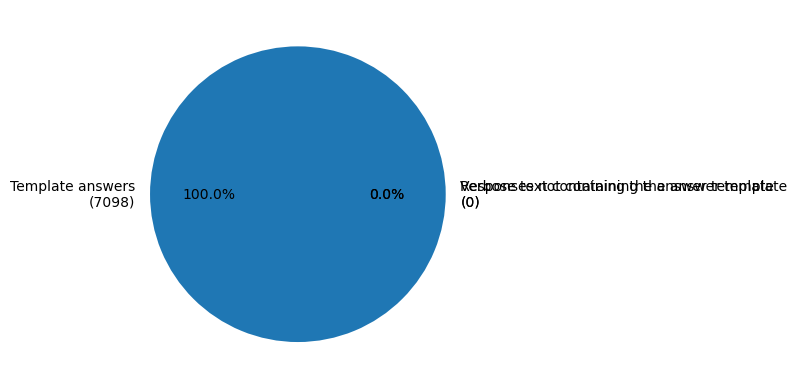

In [6]:
template_answ_count = template_answer_mask.sum()
verbose_answ_count = verbose_answer_mask.sum()
no_answ_count = (~template_answer_mask & ~verbose_answer_mask).sum()

assert sum([template_answ_count, verbose_answ_count, no_answ_count]) == predictions_df.size

labels = [f'Template answers\n({template_answ_count})', 
          f'Verbose text containing the answer template\n({verbose_answ_count})', 
          f'Responses not containing the answer template\n({no_answ_count})']

plt.pie([template_answ_count, verbose_answ_count, no_answ_count],
        labels=labels, 
        autopct='%1.1f%%')
plt.show()


Let's extract the the answers from the generated texts which do contain an answer:

In [7]:
answers_series = predictions_df.loc[template_answer_mask | verbose_answer_mask]['answer'].str.extract(r'(?i)answer: (\w+).*')[0]
answers_series.str.strip()


id
Interaction_T1_13      clothes
Interaction_T1_14        towel
Interaction_T1_31      clothes
Interaction_T1_32      clothes
Interaction_T1_40      clothes
                        ...   
Feasibility_T6_1453       wipe
Feasibility_T6_1454    walking
Feasibility_T6_1455    walking
Feasibility_T6_1456       wipe
Feasibility_T6_1468    opening
Name: 0, Length: 7098, dtype: string

In [8]:
freq = answers_series.value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 318 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

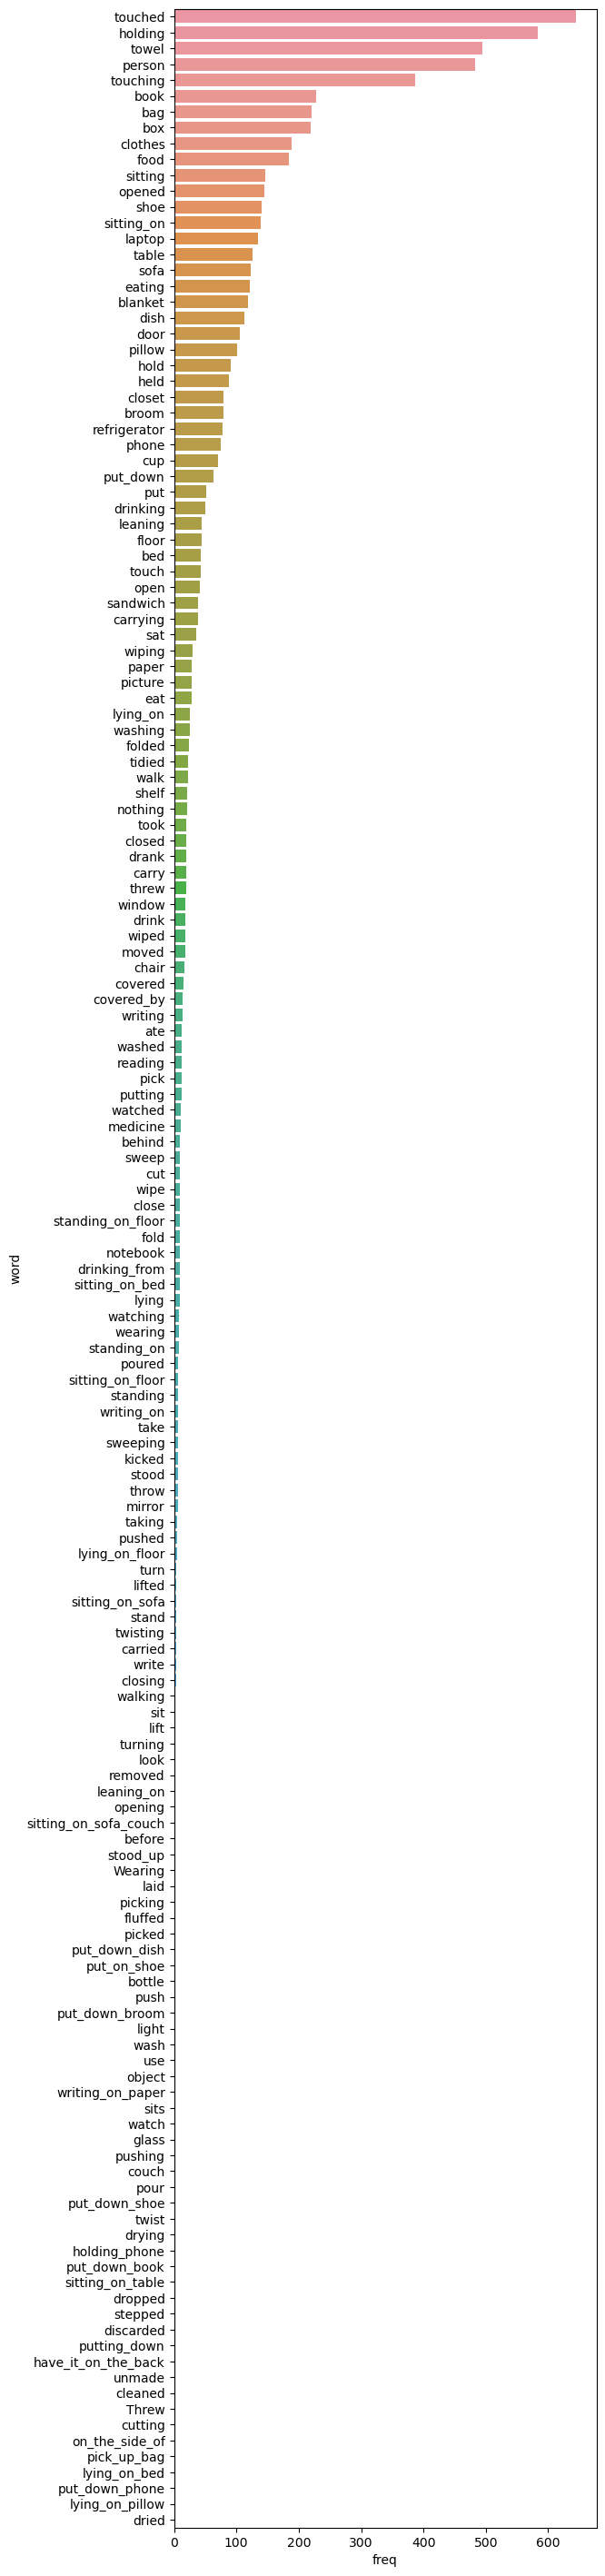

In [9]:
plt.figure(figsize=(6, 36))
sns.barplot(data=freq.sort_values('freq', ascending=False), x='freq', y='word')


We can see that there are some erroneous artifacts like `______` and `N`. Let's remove those:

In [10]:
answers_series[answers_series.str.match('^N')]


Series([], Name: 0, dtype: string)

Mmmm... We notice also many `None`, which probaly indicates that the LLM could not compute an answer. There are also a few `Not` answers, which are not descriptive enough. Let's remove them too.

In [11]:
print(f'Size before filtering: {answers_series.size}')

answers_series = answers_series[~answers_series.str.match('^N$')]
answers_series = answers_series[~answers_series.str.match('^None$')]
answers_series = answers_series[~answers_series.str.match('^Not$')]

print(f'Size after filtering: {answers_series.size}')


Size before filtering: 7098
Size after filtering: 7098


In [12]:
answers_series[answers_series.str.match('^_')]


Series([], Name: 0, dtype: string)

In [13]:
answers_series = answers_series[~answers_series.str.match('^_')]


In [14]:
answers_series = answers_series.str.replace('_', ' ')


Let's do some visualization also for the ground truth data

In [15]:
print(f"We have {gt_series.nunique()} unique answers")


We have 198 unique answers


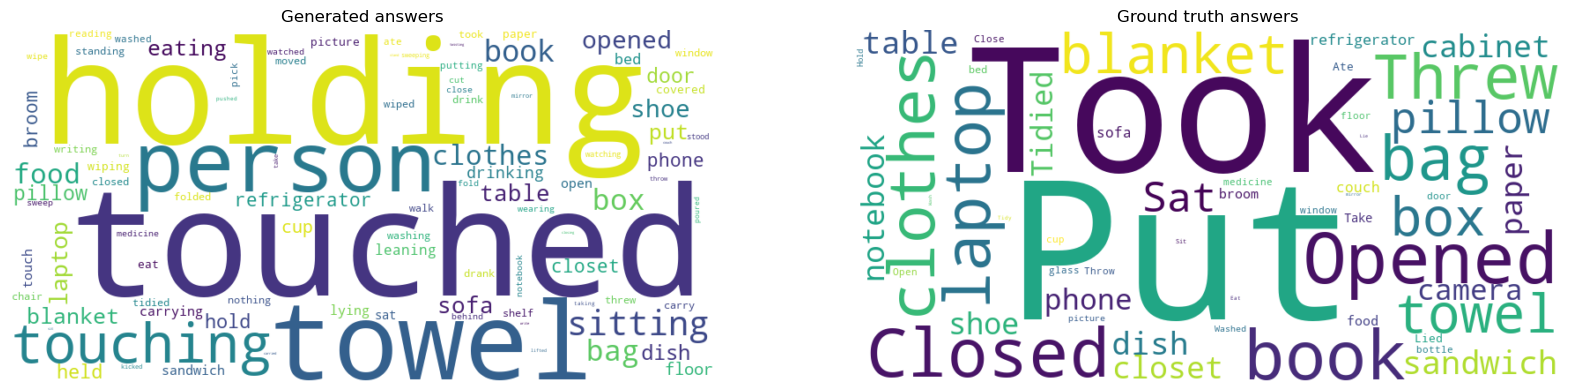

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(answers_series.astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_series.astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

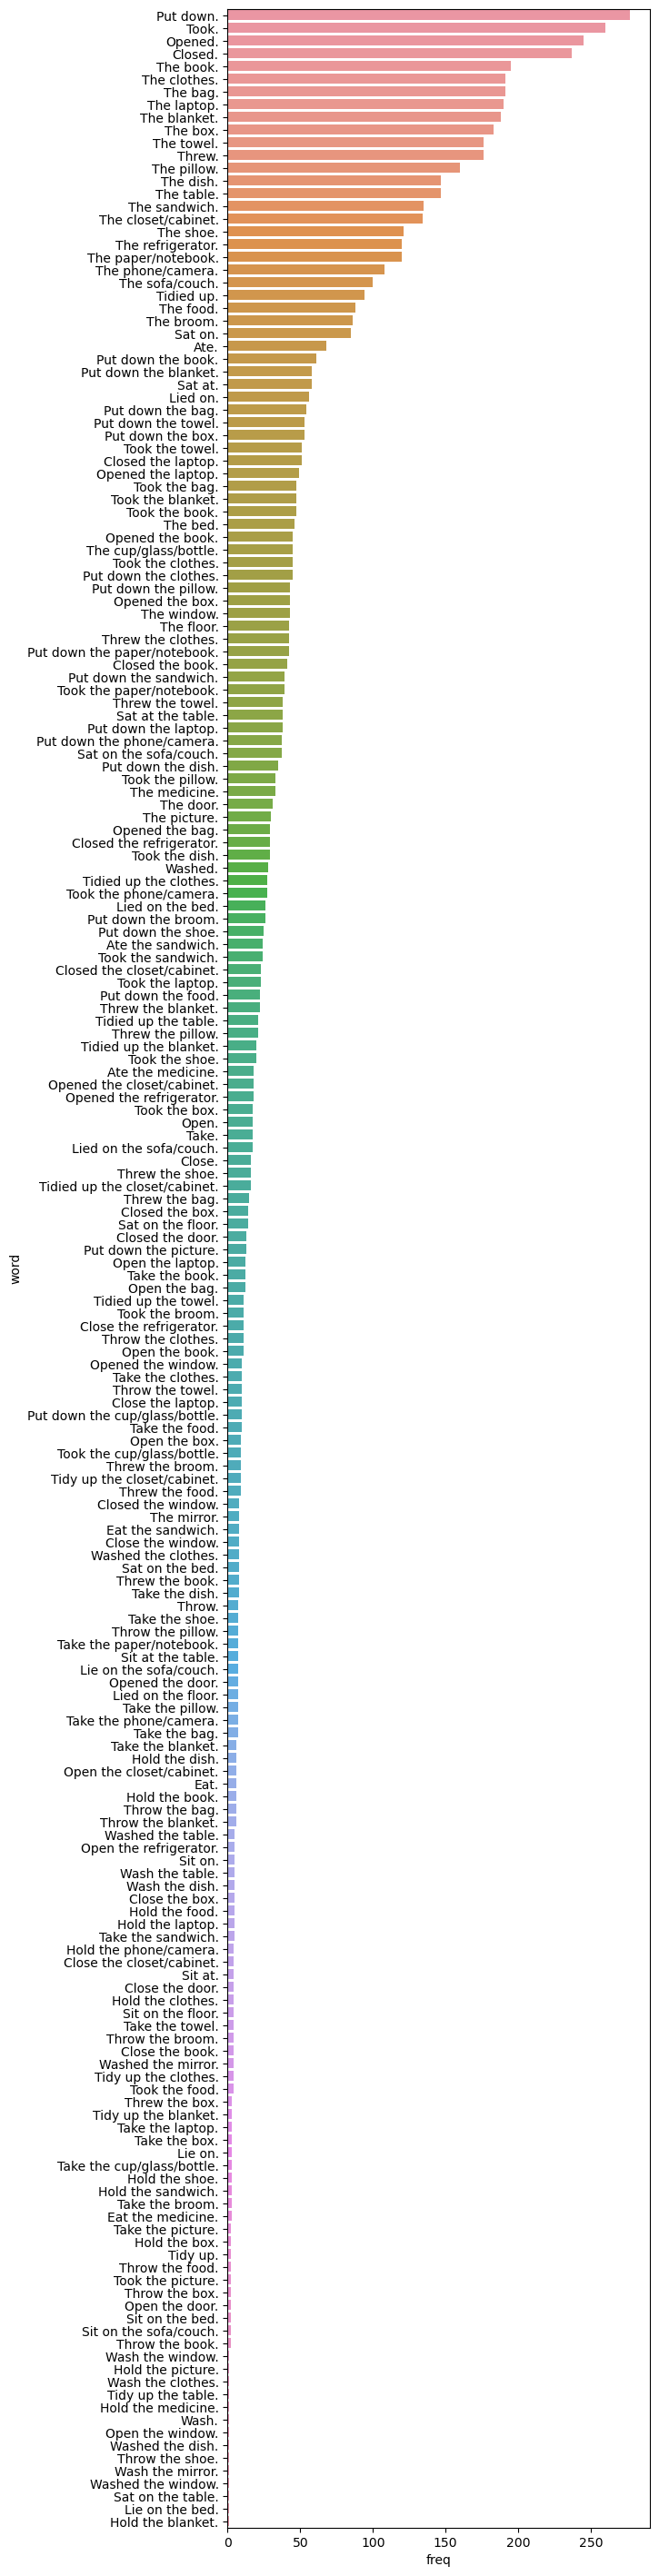

In [17]:
freq = gt_series.value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 36))
sns.barplot(data=freq.sort_values('freq', ascending=False), x='freq', y='word')


Let's remove the article 'The' from the beginning and the period from the end of the sentence. Furthermore I replace the slash  (intended as alternative) with a white space, for the moment let's keep the two alternatives:

We have 396 unique answers


<AxesSubplot: xlabel='freq', ylabel='word'>

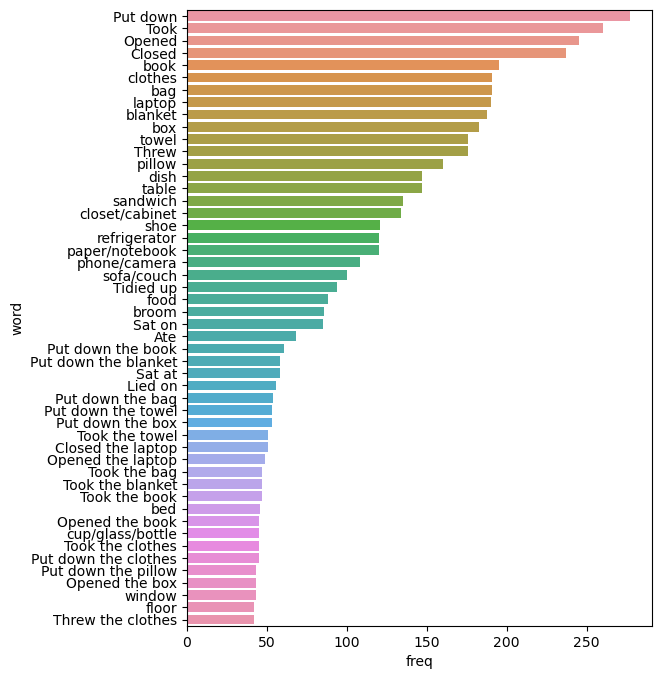

In [18]:
gt_series = gt_series.str.replace('^The', '', regex=True)
gt_series = gt_series.str.replace('.', '', regex=True)
gt_series = gt_series.str.strip()


freq = gt_series.value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [19]:
def process_string(text):
    pattern = r'^([^\/]*)\b(\w+)\/(.*)$'

    match = re.match(pattern, text)
    if match:

        before_last_word = match.group(1)

        if before_last_word:
            before_last_word = before_last_word.strip()

        last_word_before_slash = match.group(2).strip()
        part_after_slash = match.group(3).strip()

        if before_last_word:
            new_string1 = f"{before_last_word} {last_word_before_slash}"
            new_string2 = f"{before_last_word} {part_after_slash}"
        else:
            new_string1 = last_word_before_slash
            new_string2 = part_after_slash
    
        return new_string1, new_string2
    else:
        return text, ''


In [20]:
data = {'text': [
    "this is an example1/example2", 
    "another test case3/case4", 
    "no slash here", 
    "one/two/three", 
    "this is an example1/example2/example3"
]}

df = pd.DataFrame(data)

df[['first', 'second']] = df['text'].apply(process_string).apply(pd.Series)
df[['second', 'third']] = df['second'].apply(process_string).apply(pd.Series)
df


,text,first,second,third
0,this is an example1/example2,this is an example1,this is an example2,
1,another test case3/case4,another test case3,another test case4,
2,no slash here,no slash here,,
3,one/two/three,one,two,three
4,this is an example1/example2/example3,this is an example1,this is an example2,this is an example3


In [32]:
gt_df = gt_series.to_frame()

gt_df[['answer_1', 'answer_2']] = gt_df['answer'].apply(process_string).apply(pd.Series)
gt_df[['answer_2', 'answer_3']] = gt_df['answer_2'].apply(process_string).apply(pd.Series)
gt_df


,answer,answer_1,answer_2,answer_3
id,,,,
Interaction_T1_13,clothes,clothes,,
Interaction_T1_14,clothes,clothes,,
Interaction_T1_31,clothes,clothes,,
Interaction_T1_32,shoe,shoe,,
Interaction_T1_40,closet/cabinet,closet,cabinet,
...,...,...,...,...
Feasibility_T6_1453,Wash the table,Wash the table,,
Feasibility_T6_1454,Take the towel,Take the towel,,
Feasibility_T6_1455,Wash the table,Wash the table,,


In [33]:
gt_df[gt_df['answer_3'] != '']['answer_3']


id
Interaction_T1_924                  bottle
Interaction_T1_2359                 bottle
Interaction_T1_2596                 bottle
Interaction_T1_2696                 bottle
Interaction_T1_3480                 bottle
                              ...         
Feasibility_T2_1152    Put down the bottle
Feasibility_T5_2165                 bottle
Feasibility_T5_2375                 bottle
Feasibility_T6_1298    Put down the bottle
Feasibility_T6_1428        Take the bottle
Name: answer_3, Length: 67, dtype: object

In [34]:
# Inner join - keeps only indices present in both series
eval_df = gt_df.join(
    pd.DataFrame({'pred': answers_series}), 
    how='inner'
)

eval_df.shape


(7098, 5)

In [25]:
(eval_df['pred'] == eval_df['answer_1']).sum()


1776

In [26]:
(eval_df['pred'] == eval_df['answer_2']).sum()


8

In [27]:
(eval_df['pred'] == eval_df['answer_3']).sum()


0

In [46]:
(eval_df['pred'] == eval_df['answer']).sum()


1532

In [44]:
((eval_df['pred'] == eval_df['answer']) & (eval_df['pred'] == eval_df['answer_1'])).sum()


1532

In [47]:
def accuracy(eval_df):
    hits = (eval_df['pred'] == eval_df['answer_1']).sum()
    hits += (eval_df['pred'] == eval_df['answer_2']).sum()
    hits += (eval_df['pred'] == eval_df['answer_3']).sum()
    
    return hits/eval_df.shape[0]
    

In [48]:
print(f"Accuracy: {accuracy(eval_df):.2%}")


Accuracy: 25.13%


Careful, the accuracy value above is compute considering only the samples for which the LLM outputs a sequence of text respeting the template (does not hallucinate). The real accuracy value, accounting for questions not answered is:

In [49]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 25.13%


In [50]:
print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

total = eval_df.index.str.startswith('Interaction').sum()
acc = accuracy(eval_df[eval_df.index.str.startswith('Interaction')])
print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

total = eval_df.index.str.startswith('Sequence').sum()
acc = accuracy(eval_df[eval_df.index.str.startswith('Sequence')])
print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

total = eval_df.index.str.startswith('Prediction').sum()
acc = accuracy(eval_df[eval_df.index.str.startswith('Prediction')])
print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

total = eval_df.index.str.startswith('Feasibility').sum()
acc = accuracy(eval_df[eval_df.index.str.startswith('Feasibility')])
print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


Question type       Total      Accuracy 

Interaction         2398        32.86%  
Sequence            3586        22.17%  
Prediction           624        18.11%  
Feasibility          490        17.96%  
